<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Amount,-Time-Scaling" data-toc-modified-id="Amount,-Time-Scaling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Amount, Time Scaling</a></span></li><li><span><a href="#Time-to-Day,Hour-dummies" data-toc-modified-id="Time-to-Day,Hour-dummies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time to Day,Hour dummies</a></span></li><li><span><a href="#Select-V-with-T-test,-KS-test" data-toc-modified-id="Select-V-with-T-test,-KS-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Select V with T-test, KS-test</a></span></li><li><span><a href="#변수-선택" data-toc-modified-id="변수-선택-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>변수 선택</a></span></li><li><span><a href="#평가" data-toc-modified-id="평가-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>평가</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Save-df-to-csv" data-toc-modified-id="Save-df-to-csv-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save df to csv</a></span></li></ul></div>

In [12]:
# 전처리, 차원축소, 평가 모듈
import module.muresa as muresa

# 데이터 입출력
import numpy as np
import pandas as pd

# 검정 
import scipy.stats as st

# 전처리
from sklearn.preprocessing import MinMaxScaler,RobustScaler,Normalizer
from sklearn.decomposition import PCA,TruncatedSVD # 차원축소

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 시각화
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sb

# second to dd:hh:mm:ss
import datetime

# pipeline
from sklearn.pipeline import Pipeline

# model save
import pickle

In [13]:
df = pd.read_csv(r'data/creditcard.csv')

# Amount, Time Scaling

In [14]:
# scaling Amount, Time
df['Amount'] = df.Amount.apply(lambda x : np.log(x+0.0001))
df['Time_scaled'] =  muresa.robustScale(df['Time'])

# Time to Day,Hour dummies

In [15]:
# second to Day Hour
df['Time_str'] = df['Time'].apply(lambda s : str(datetime.timedelta(seconds=s)))
df['Day'] = df['Time_str'].apply(lambda s: '0' if len(s.split(","))==1 else s.split(",")[0][0])
df['Hour'] = df['Time_str'].apply(lambda s: s.split(",")[-1].split(":")[0].strip())
#df.drop(columns='Time_str',inplace = True)

# Hour to dummies
df['Hour'] = df['Hour'].apply(Hour2num)
hour_dummies = pd.get_dummies(df['Hour'],drop_first=True,prefix='Hour')
day_dummies = pd.get_dummies(df['Day'],drop_first=True,prefix='Day')

# Amount to dummies
df['Amount_interval']=pd.qcut(df.Amount,10)
df['Amount_interval'] = df['Amount_interval'].apply(log_Amount_interval2num)
amount_dummies = pd.get_dummies(df['Amount_interval'],drop_first=True,prefix='Amount')

# Day:Hour interaction term
day_hour_dummies = pd.DataFrame(np.multiply(day_dummies.values,hour_dummies.values))
day_hour_dummies.columns = ['Day1*Hour2','Day1*Hour3','Day1*Hour4','Day1*Hour5','Day1*Hour6']

# Select V with T-test, KS-test

In [16]:
# t-test, ks-test for V
v_list = list(df.columns[1:29])
t_pval_list = []
ks_pval_list = []

for v in v_list:
    t_pval, ks_pval = compare2dist(df,v)
    t_pval_list.append(t_pval)
    ks_pval_list.append(ks_pval)

In [17]:
pval = pd.DataFrame(list(zip(t_pval_list, ks_pval_list)))
pval.columns = ['t-test','ks-test']
pval.index = v_list

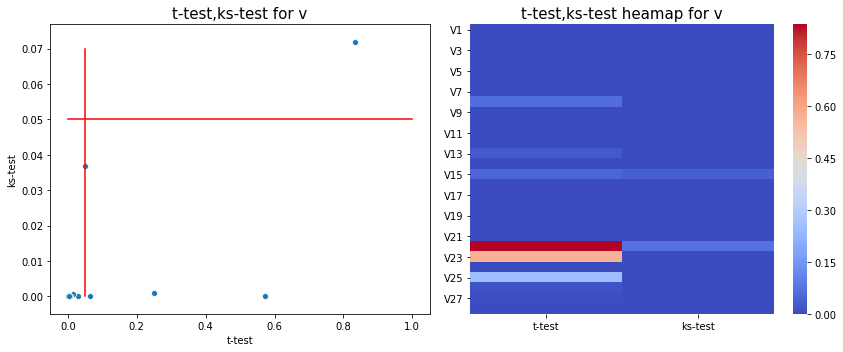

In [18]:
fig,ax = plt.subplots(1,2,figsize = (12,5))
sb.scatterplot(pval['t-test'],pval['ks-test'],ax=ax[0])
ax[0].plot([0.05,0.05],[0,0.07],color = 'red')
ax[0].plot([0,1],[0.05,0.05],color = 'red')
ax[0].set_title('t-test,ks-test for v',fontsize = 15)
sb.heatmap(pval,cmap = 'coolwarm',ax=ax[1])
ax[1].set_title('t-test,ks-test heamap for v',fontsize =15)
plt.tight_layout()
plt.show()

In [19]:
# ks-test, t-test 둘다 통과
# v15 는 0.0049 간당간당함
pval.loc[(pval['ks-test']<0.05)&(pval['t-test']<0.05),:].index

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V24',
       'V26', 'V27', 'V28'],
      dtype='object')

In [20]:
# ks-test, t-test 둘다 통과 못함
pval.loc[(pval['ks-test']>0.05)&(pval['t-test']>0.05),:].index

Index(['V22'], dtype='object')

In [21]:
# t-test 통과 못함
pval.loc[(pval['t-test']>0.05),:].index

Index(['V8', 'V22', 'V23', 'V25'], dtype='object')

# 변수 선택

In [22]:
# Original, -Time
df_1 = df.drop(columns=['Time','Time_str','Day', 'Hour', 'Amount_interval'])
df_2 = df.drop(columns=['Time','Time_str','Day', 'Hour', 'Amount_interval','Time'])

# Dummies
df_3 = df.drop(columns=['Amount','Time','Time_str','Day', 'Hour','Time_scaled','Amount_interval'])
df_3 = pd.concat([df_3,amount_dummies,day_dummies,hour_dummies],axis = 1)
df_4 = pd.concat([df_3,amount_dummies,day_dummies,hour_dummies,day_hour_dummies],axis = 1) # day:hour interaction

# V 
v_not_good = ['V10','V12','V14','V16','V17','V18']
v_bad = ['V1','V2','V5','V6','V8','V13','V15','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28']
kst_bad = ['V8','V15','V22','V23','V25']
df_5 = df.drop(['Time','Time_str','Day', 'Hour', 'Amount_interval','Time']+v_not_good+v_bad,axis =1)
df_6 = df.drop(['Time','Time_str','Day', 'Hour', 'Amount_interval','Time']+v_bad,axis =1)
df_7 = df.drop(['Time','Time_str','Day', 'Hour', 'Amount_interval','Time']+kst_bad,axis =1)

# 평가

d:\pl\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\pl\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\pl\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\pl\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\pl\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

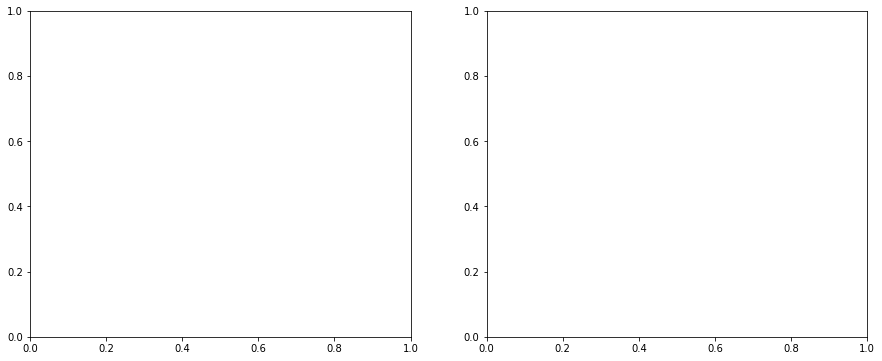

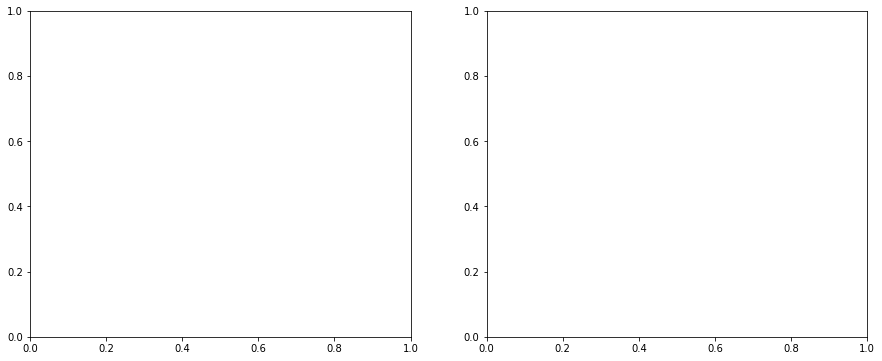

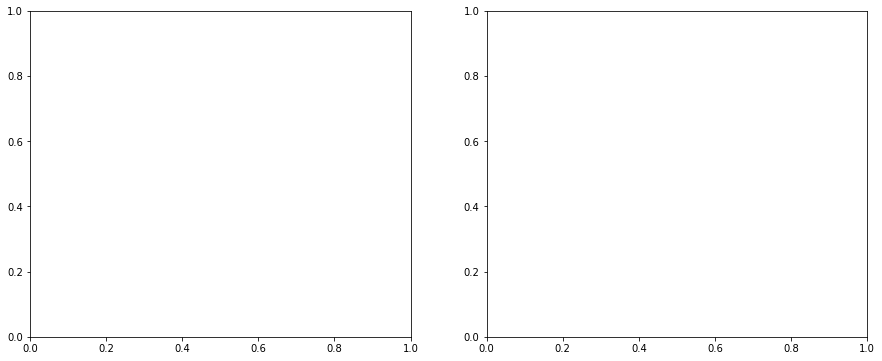

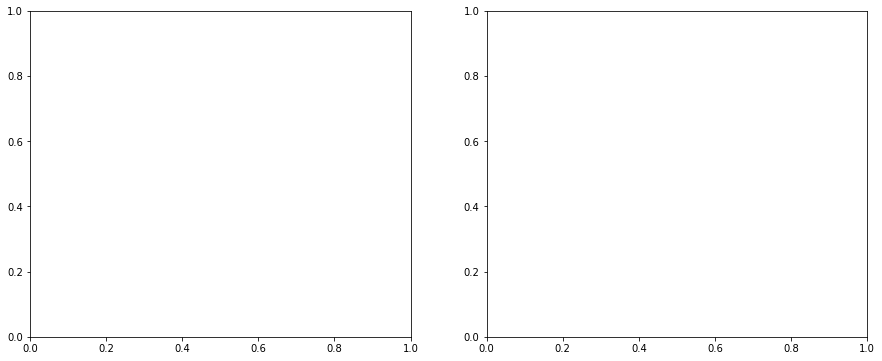

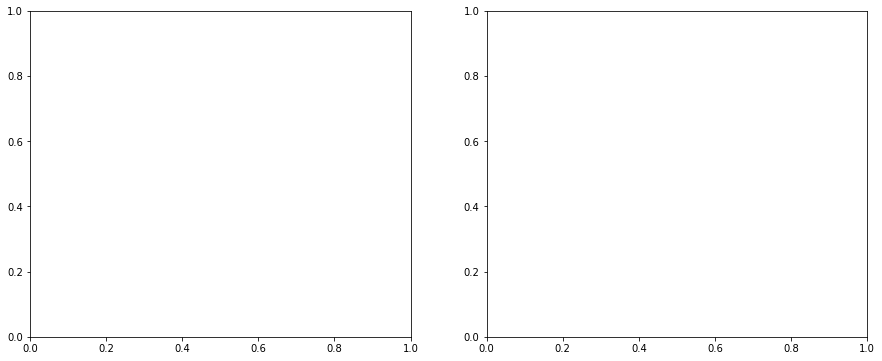

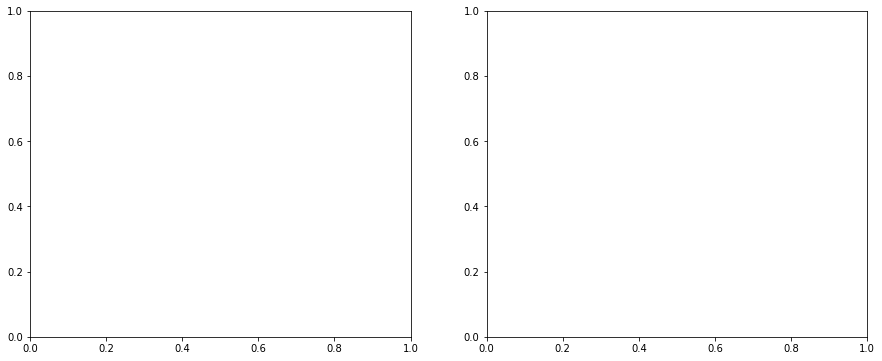

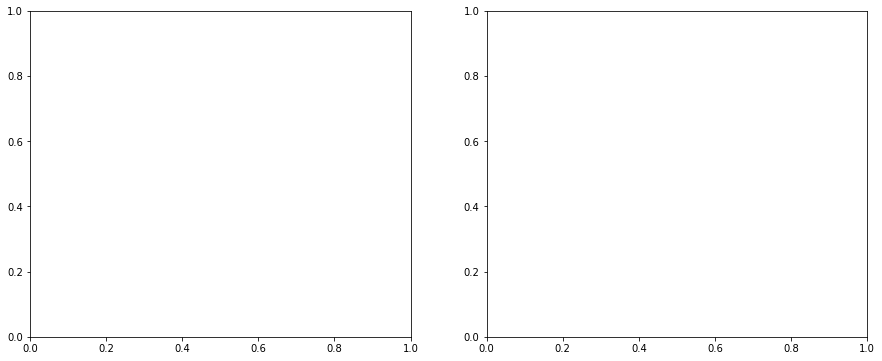

In [41]:
df_list = [df_1,df_2,df_3,df_4,df_5,df_6,df_7]
res = []
for df in df_list:
    res.append(Eval(df))

In [43]:
pd.DataFrame(res)

,acc,average precision,confusion matrix,f1 score,precision,recall
0,0.999040,0.758833,"[[85266, 17], [65, 95]]",0.698529,0.848214,0.59375
1,0.999040,0.758833,"[[85266, 17], [65, 95]]",0.698529,0.848214,0.59375
2,0.999064,0.766860,"[[85265, 18], [62, 98]]",0.710145,0.844828,0.61250
3,0.999075,0.770956,"[[85265, 18], [61, 99]]",0.714801,0.846154,0.61875
4,0.998795,0.647056,"[[85266, 17], [86, 74]]",0.589641,0.813187,0.46250
5,0.999029,0.750516,"[[85266, 17], [66, 94]]",0.693727,0.846847,0.58750
6,0.999017,0.757745,"[[85267, 16], [68, 92]]",0.686567,0.851852,0.57500


In [158]:
x,y = df_3.drop(columns = 'Class'),df_3.Class
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 123)

# smapling with Trainset
x_train_sm,x_test_sm, y_train_sm, y_test_sm = muresa.SMOTESampling(x_train,y_train, over = 0.4, ratio = 0.3,random_state=123)

glm = LogisticRegression()
glm.fit(x_train_sm,y_train_sm)

d:\pl\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Functions

In [7]:
#Hour_interval to num(4 Feature Engineering - 4.1. time(Hour)
def Hour2num(hour):
    res = '0'
    if hour == '2' :res =  '1'
    elif hour == '4' : res = '2'
    elif (hour == '3')or(hour =='5'): res = '3'
    elif hour == '7' : res = '4'
    elif hour == '11': res = '5'
    else :res = '6'
    return res

In [8]:
#log_Amount_interval to num(4.Feature Engineering - 4.1. Amount)
def log_Amount_interval2num(interval):
    interval = str(interval)
    # 1
    if (interval) == '(-9.211, 0.0001]':
        return '1'
    # 10
    elif (interval) == '(5.313, 10.154]':
        return '2'
    # 2,3,8,9 / 나머지로 나눠보니까 비율이 비슷해서 합침
    else : return '3'

In [37]:
# Evaluation
def evaluation_class(y_true,y_pred,true_idx=1,thresholds = 0.5):
    
    from sklearn import metrics # for result
    import matplotlib.pyplot as plt # for visualization
    
    # tranform y_pred into integer array
    y_pred_val = ([1 if prob>thresholds else 0 for prob in y_pred[:,true_idx]])
    # counfusion matrix
    conf_mat = metrics.confusion_matrix(y_true,y_pred_val)
    
    #acc
    acc = metrics.accuracy_score(y_true,y_pred_val)   
    #recall
    re = metrics.recall_score(y_true,y_pred_val) 
    #precision
    pre = metrics.precision_score(y_true,y_pred_val)
    #f1
    f1 = metrics.f1_score(y_true,y_pred_val)   
    #average precsion
    avg_pre = metrics.average_precision_score(y_true,y_pred[:,true_idx])  
    
    # visualization
    fig,ax = plt.subplots(1,2,figsize = (15,6))
    
    # ROC
    #fpr,tpr,thresholds = metrics.roc_curve(y_true,y_pred[:,true_idx])
    #ax[0].plot(fpr,tpr,color = 'b')
    #ax[0].set_title('ROC Curve',fontsize = 15)
    #ax[0].set_xlabel('1- FP')
    #ax[0].set_ylabel('TP')
    
    # PR
    #precision,recall,thresholds = metrics.precision_recall_curve(y_true,y_pred[:,true_idx])
    #ax[1].step(recall,precision,color = 'r', where = 'post')
    #ax[1].set_title('PR Curve',fontsize = 15)
    #ax[1].set_xlabel('Recall')
    #ax[1].set_ylabel('Precision')
    
    
    # 결과 저장
    result_dic = {
        'confusion matrix':conf_mat,
        'acc':acc,
        'recall':re,
        'precision':pre,
        'f1 score':f1,
        'average precision':avg_pre
    }
    return result_dic

In [40]:
def Eval(df):
    
    x,y = df.drop(columns = 'Class'),df.Class
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 123)

    #smapling with Trainset
    x_train_sm,x_test_sm, y_train_sm, y_test_sm = muresa.SMOTESampling(x_train,y_train, over = 0.4, ratio = 0.3,random_state=123)

    glm = LogisticRegression()
    glm.fit(x_train,y_train)
    
    #in sample evaluation
    #print('In-sample test')
    #print('='*100)
    #y_pred = glm.predict_proba(x_test_sm)
    #print(evaluation_class(y_test_sm,y_pred))
    #print('='*100)
    #print('Out-sample test')
    
    # out sample evaluation
    y_pred_all = glm.predict_proba(x_test)
    #print(evaluation_class(y_test,y_pred_all))
    
    return evaluation_class(y_test,y_pred_all)

In [11]:
# compare distribution  Fraud - No Fraud data for V
def compare2dist(df,v):
    
    fraud,no_fraud = df.loc[df['Class']==0,v].values,df.loc[df['Class']==1,v].values
    
    # t-test
    t_pval = st.ttest_ind(fraud,no_fraud,equal_var=False)[1]
    
    # 2 sample ks test
    ks_pval = st.ks_2samp(fraud,no_fraud)[1]
    
    return t_pval, ks_pval
    

# Save df to csv

In [154]:
for i in range(1,8):
    globals()[f'df_{i}'].to_csv(f'D:\\document\\data_project\\Kaggle\card_fraud\\data\\df_{i}.csv')